# Part 2.2

her har systemet en overflow-struktur. Det betyr at vannet ikke går direkte til målepunktet, men at det må samle seg opp til et visst nivå før det begynner å renne over i den delen av systemet hvor målingen gjøres.

Dette gir ikke-lineær oppførsel, som skiller seg fra det enkle lineære reservoarmodellen i 2.1.

In [5]:

# Load package
library(e1071)
library(ctsmTMB)
library(dplyr)
library(lubridate)
library(readr)
library(ggplot2)
library(data.table)
library(ggplot2)
library(patchwork)

###       PART 2       ###

data <- read.csv("data/ex2_overflow.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)


# build the data frame the model expects
data <- data %>%
  mutate(
    time = as.POSIXct(timestamp, format = "%Y-%m-%d %H:%M:%S", tz = "UTC"),
    t = as.numeric(difftime(time, min(time), units = "hour"))
  ) %>%
  arrange(t) %>%
  select(t, rainfall, stormwater)

#data$t <- data$t/60

tail(data)


,t,rainfall,stormwater
,<dbl>,<dbl>,<dbl>
596,9.916667,0,9.068
597,9.933333,0,9.071
598,9.950000,0,9.076
599,9.966667,0,9.059
600,9.983333,0,9.026
601,10.000000,0,9.038


## 2.2.1

In [6]:
model <- ctsmTMB$new()

# Differential Equation
n = 3

model$addSystem(
  dx1 ~ A * rainfall * dt - (3/K) * x1 * dt + sigma_x * dw1,
  dx2 ~ (3/K) * x1 * dt - (3/K) * x2 * dt + sigma_x * dw2,
  dx3 ~ (3/K) * x2 * dt - (3/K) * x3 * dt + sigma_x * dw3,
  dx4 ~ (3/K) * x3 * dt + sigma_x * dw4
)

#Parameters and estimation
model$addObs(stormwater ~ x4)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 1,  lower = 1e-6, upper = 1e3),
  K       = c(initial = 10, lower = 1e-6, upper = 1e4),
  sigma_x = c(initial = 0.1, lower = 1e-8, upper = 10),
  sigma_y = c(initial = 0.1, lower = 1e-8, upper = 10)
)
model$setInitialState(list(c(0, 0, 0, 0), diag(c(0.1, 0.1, 0.1, 0.1)) ))

# now estimate
fit <- model$estimate(data)

summary(fit)
print(fit)

A       <- coef(fit)["A"]
K       <- coef(fit)["K"]
sigma_x <- coef(fit)["sigma_x"]
sigma_y <- coef(fit)["sigma_y"]


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:     731.15582:  1.00000  10.0000 0.100000 0.100000
 10:    -1211.7308:  1.84141  4.34491 0.251015 1.00000e-08
 20:    -1269.0604:  2.46389  2.26770 0.242104 1.00000e-08
 30:    -1385.4631:  1.63586  2.27292 0.171084 1.00000e-08
 40:    -1471.9965:  1.09664  1.45070 0.159417 1.00000e-08


	 Optimization finished!:
            Elapsed time: 0.142 seconds.
            The objective value is: -1.471997e+03
            The maximum gradient component is: 4.2e-03
            The convergence message is: relative convergence (4)
            Iterations: 40
            Evaluations: Fun: 59 Grad: 41
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
          Estimate Std. Error t value Pr(>|t|)    
A       1.09664060 0.05707046  19.216   <2e-16 ***
K       1.45070179 0.05825150  24.904   <2e-16 ***
sigma_x 0.15941725 0.00461006  34.580   <2e-16 ***
sigma_y 0.00000001 0.00154065   0.000        1    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Coefficent Matrix 
          Estimate Std. Error t value Pr(>|t|)    
A       1.09664060 0.05707046  19.216   <2e-16 ***
K       1.45070179 0.05825150  24.904   <2e-16 ***
sigma_x 0.15941725 0.00461006  34.580   <2e-16 ***
sigma_y 0.00000001 0.00154065   0.000        1    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Plot of the linear model

Number of reservoirs (n): 3 
Number of states: 4 


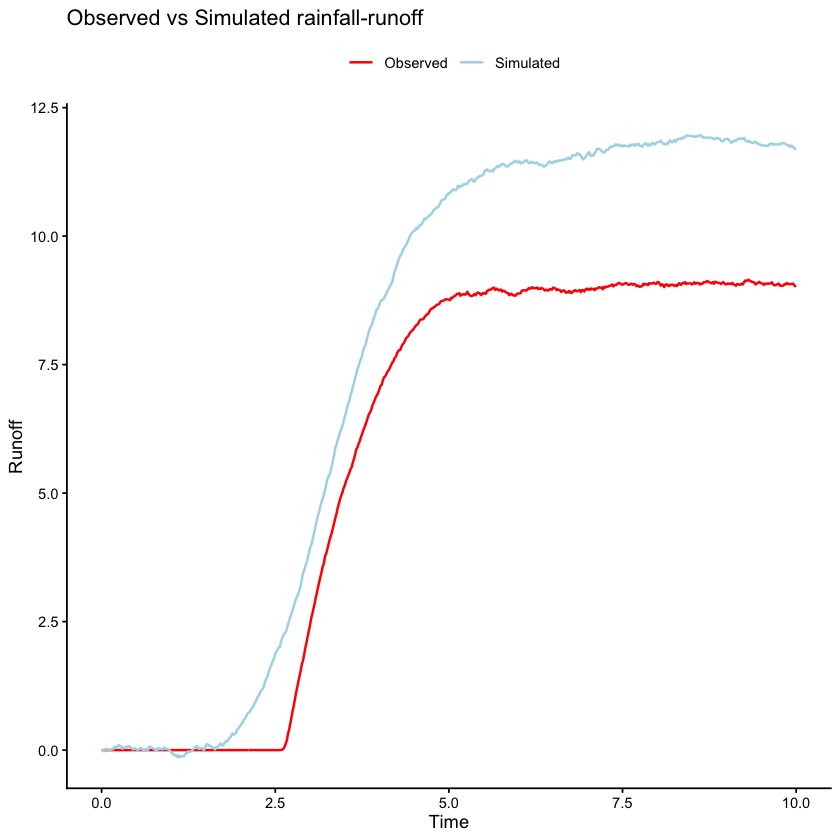

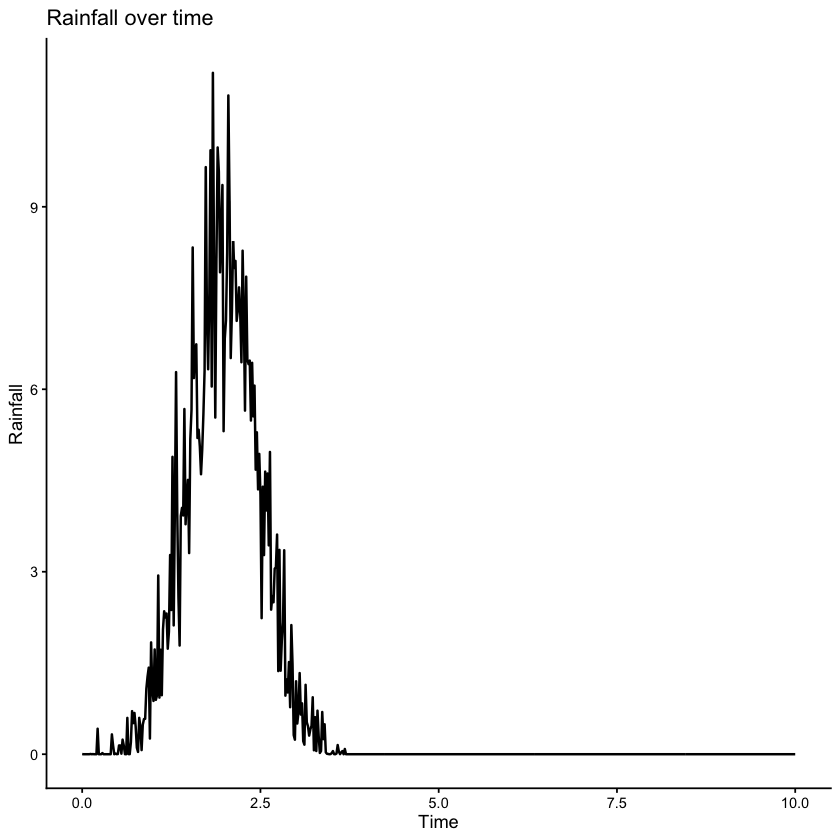

In [7]:
# ---- Choose n (same n as in your ctsmTMB model) ----
n <- 3                 # e.g. 1, 2, 3, ..., 6
n_states <- n + 1      # x1, x2, ..., x_{n+1}

cat("Number of reservoirs (n):", n, "\n")
cat("Number of states:", n_states, "\n")

# ---- Coefficients from fit (or take from coef(fit)) ----
A <- 1.0870
K <- 1.4297
sigma_x <- 0.1599
sigma_y <- 0.0000001

# Time handling 
time <- if ("t" %in% names(data)) data$t else data$time
time_num <- as.numeric(time)
n_t <- length(time_num)

rain <- data$rainfall
rain[!is.finite(rain)] <- 0

# State matrix: rows = time, cols = x1..x_{n+1} 
X <- matrix(0, nrow = n_t, ncol = n_states)
colnames(X) <- paste0("x", 1:n_states)

set.seed(123)

# Euler–Maruyama simulation matching your SDE structure 
for (i in 2:n_t) {
  dt_i <- time_num[i] - time_num[i - 1]
  stopifnot(is.finite(dt_i) && dt_i > 0)

  # Brownian increments for each state
  dw <- rnorm(n_states, mean = 0, sd = sqrt(dt_i))

  # previous state
  x_prev <- X[i - 1, ]

  # 1) First reservoir:
  
  X[i, 1] <- x_prev[1] +
    (A * rain[i] - (n / K) * x_prev[1]) * dt_i +
    sigma_x * dw[1]

  # 2) Middle reservoirs (if any)
  if (n_states > 2) {
    for (k in 2:(n_states - 1)) {
      # dx_k = (n/K)*x_{k-1} - (n/K)*x_k + noise
      X[i, k] <- x_prev[k] +
        ((n / K) * x_prev[k - 1] - (n / K) * x_prev[k]) * dt_i +
        sigma_x * dw[k]
    }
  }

  # 3) Last reservoir:
  X[i, n_states] <- x_prev[n_states] +
    ( (n / K) * x_prev[n_states - 1] ) * dt_i +
    sigma_x * dw[n_states]
}

# Runoff / stormwater = last state x_{n+1} 
stormwater_sim <- X[, n_states]


df_plot <- data.frame(
  time      = time,
  observed  = data$stormwater,
  simulated = stormwater_sim,
  rainfall  = data$rainfall
)



ggplot(df_plot, aes(x = time)) +
  geom_line(aes(y = observed,  color = "Observed"), linewidth = 0.7) +
  geom_line(aes(y = simulated, color = "Simulated"), linewidth = 0.7) +
  scale_color_manual(values = c("Observed" = "red",
                                "Simulated" = "lightblue")) +
  labs(
    title = "Observed vs Simulated rainfall-runoff",
    y = "Runoff",
    x = "Time",
    color = ""          # Legend title
  ) +
  theme_classic() +
  theme(
    plot.title = element_text(size = 13),
    legend.position = "top"   # move legend above plot (assignment style)
  )


## ---- Plot 2: Rainfall ----
ggplot(df_plot, aes(x = time, y = rainfall)) +
  geom_line(linewidth = 0.7, color = "black") +
  labs(
    title = "Rainfall over time",
    y = "Rainfall",
    x = "Time"
  ) +
  theme_classic() +
  theme(
    plot.title = element_text(size = 13)
  )



Checking and setting data...

Predicting with R...

Returning results...

Finished!



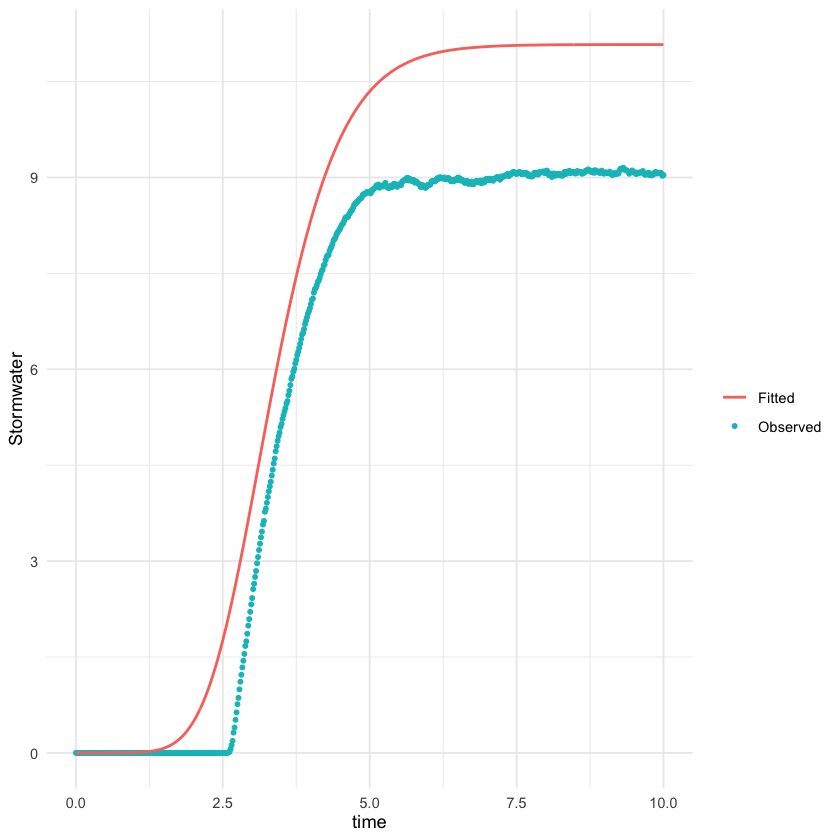

In [8]:
plot_ctsm_fits <- function(model, data, 
                           response = "stormwater",
                           time_var = "t"
                          ) {
  
  pred <- model$predict(data = data)

  obs <- pred$observations

  df <- data.frame(
    time      = obs$t.j,              
    observed  = obs$stormwater.data,
    fitted    = obs$stormwater  
  )

  ggplot(df, aes(x = time)) +
    geom_point(aes(y = observed, colour = "Observed"), size = 1) +
    geom_line(aes(y = fitted, colour = "Fitted"), linewidth = 0.8) +
    labs(y = "Stormwater", colour = "") +
    theme_minimal()
}

plot_ctsm_fits(model, data,
               response = "stormwater",
               time_var = "t")


### 2.2.2

In [9]:
model <- ctsmTMB$new()

n <- 3

model$addSystem(
  dx1 ~ A * rainfall * dt - (3 / K) * x1 * dt + sigma_x * dw1,
  dx2 ~ (3 / K) * x1 * dt - (3 / K) * x2 * dt + sigma_x * dw2,
  dx3 ~ (3 / K) * x2 * dt - (3 / K) * x3 * dt + sigma_x * dw3,
  dx4 ~ (3 / K) * x3 * (1 / (1 + exp(-alpha * (x3 - beta)))) * dt + sigma_x * dw4
)

model$addObs(stormwater ~ x4)
model$setVariance(stormwater ~ sigma_y^2)
model$addInput(rainfall)

model$setParameter(
  A       = c(initial = 0.9,  lower = 1e-6, upper = 10),
  K       = c(initial = 1.3,  lower = 1e-3, upper = 20),
  sigma_x = c(initial = 0.15, lower = 1e-4, upper = 5),
  sigma_y = c(initial = 0.01, lower = 1e-4, upper = 5),
  alpha   = c(initial = 5,    lower = 0.1,  upper = 10),
  beta    = c(initial = 2,    lower = 0.5,  upper = 6)
)

model$setInitialState(list(c(0, 0, 0, 0), diag(c(0.1, 0.1, 0.1, 0.1))))

fit_222 <- model$estimate(data)
summary(fit_222)


Checking model components...

Checking and setting data...

Constructing objective function and derivative tables...

Minimizing the negative log-likelihood...



  0:    -1412.7396: 0.900000  1.30000 0.150000 0.0100000  5.00000  2.00000
 10:    -1512.9156:  1.10798  1.54747 0.147897 0.000100000  4.99876  1.94737
 20:    -1524.4388:  1.24881  1.71655 0.148282 0.000244013  4.94734  2.18275
 30:    -1525.2041:  1.26180  1.74540 0.147775 0.000263531  4.93278  2.22359
 40:    -1527.5837:  1.41827  1.75727 0.144376 0.00204717  4.01479  2.38150
 50:    -1528.3029:  1.46779  1.70993 0.144803 0.00178821  2.90809  2.33278


	 Optimization finished!:
            Elapsed time: 0.196 seconds.
            The objective value is: -1.528303e+03
            The maximum gradient component is: 4.2e-04
            The convergence message is: relative convergence (4)
            Iterations: 52
            Evaluations: Fun: 78 Grad: 53
            See stats::nlminb for available tolerance/control arguments.

Returning results...

Finished!



Coefficent Matrix 
         Estimate Std. Error t value  Pr(>|t|)    
A       1.4677150  0.0912744 16.0802 < 2.2e-16 ***
K       1.7099554  0.0696187 24.5617 < 2.2e-16 ***
sigma_x 0.1447935  0.0066020 21.9317 < 2.2e-16 ***
sigma_y 0.0017928  0.0034657  0.5173 0.6051398    
alpha   2.9089411  0.7756498  3.7503 0.0001939 ***
beta    2.3327380  0.2082525 11.2015 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 1.467714996 1.709955426 0.144793490 0.001792794 2.908941058 2.332737995


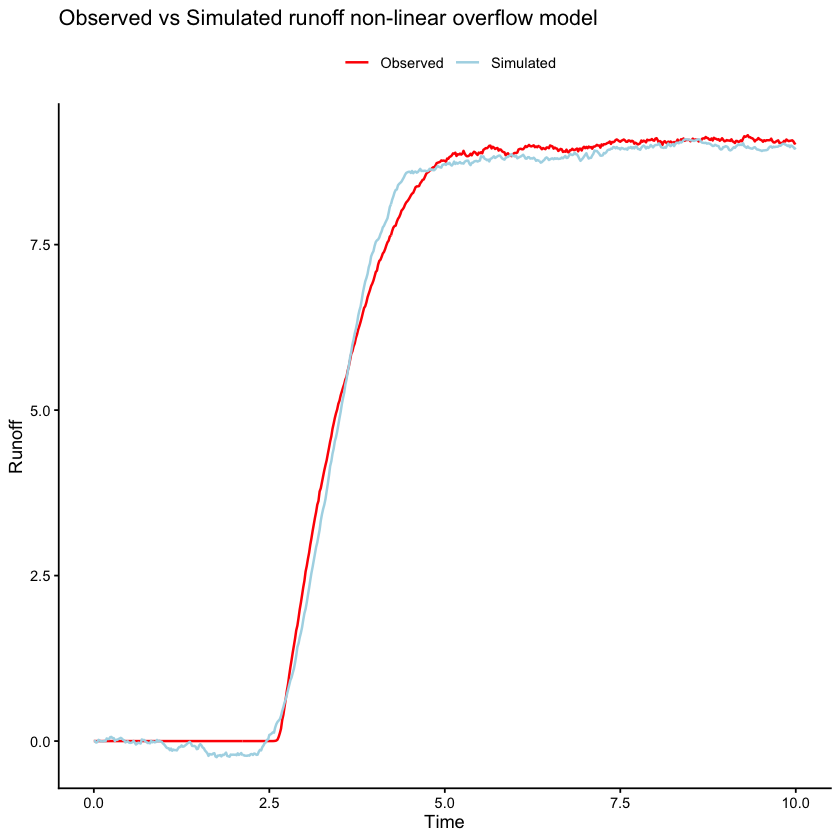

In [10]:
library(ggplot2)

# ---- Parameters from the non-linear fit (2.2.2) ----
par_hat <- model$getParameters(type = "all", value = "estimate")
print(par_hat)

A       <- 1.433
K       <- 1.670
sigma_x <- 0.147
sigma_y <- 0.001
alpha   <- 2.855
beta    <- 2.209

# ---- Time and input ----
time     <- data$t
time_num <- as.numeric(time)
n_t      <- length(time_num)

rain <- data$rainfall
rain[!is.finite(rain)] <- 0

n        <- 3
n_states <- n + 1

X <- matrix(0, nrow = n_t, ncol = n_states)
colnames(X) <- paste0("x", 1:n_states)

set.seed(123)

for (i in 2:n_t) {
  dt_i <- time_num[i] - time_num[i - 1]
  stopifnot(is.finite(dt_i) && dt_i > 0)

  dw     <- rnorm(n_states, 0, sqrt(dt_i))
  x_prev <- X[i - 1, ]

  # linear part:
  X[i, 1] <- x_prev[1] +
    (A * rain[i] - (n / K) * x_prev[1]) * dt_i + sigma_x * dw[1]

  X[i, 2] <- x_prev[2] +
    ((n / K) * x_prev[1] - (n / K) * x_prev[2]) * dt_i + sigma_x * dw[2]

  X[i, 3] <- x_prev[3] +
    ((n / K) * x_prev[2] - (n / K) * x_prev[3]) * dt_i + sigma_x * dw[3]

  # non-linear overflow into x4:
  q <- 1 / (1 + exp(-alpha * (x_prev[3] - beta)))
  X[i, 4] <- x_prev[4] +
    ((n / K) * x_prev[3] * q) * dt_i + sigma_x * dw[4]
}

stormwater_sim <- X[, 4]

df_plot <- data.frame(
  time      = time,
  observed  = data$stormwater,
  simulated = stormwater_sim,
  rainfall  = data$rainfall
)

# ---- Plot 1: Observed vs simulated (2.2.2) ----
ggplot(df_plot, aes(x = time)) +
  geom_line(aes(y = observed,  color = "Observed"), linewidth = 0.7) +
  geom_line(aes(y = simulated, color = "Simulated"), linewidth = 0.7) +
  scale_color_manual(values = c("Observed" = "red",
                                "Simulated" = "lightblue")) +
  labs(
    title = "Observed vs Simulated runoff non-linear overflow model",
    y = "Runoff",
    x = "Time",
    color = ""
  ) +
  theme_classic() +
  theme(
    legend.position = "top",
    plot.title = element_text(size = 13)
  )



## 2.2.3

In [11]:
# Assuming you already have: fit <- model$estimate(data)

f <- fit_222

cov_mat <- f$cov.fixed

cor_mat <- cov2cor(cov_mat)

round(cor_mat, 3)



,A,K,sigma_x,sigma_y,alpha,beta
A,1.000,-0.111,0.007,-0.004,-0.683,0.614
K,-0.111,1.000,-0.001,-0.002,0.413,0.422
sigma_x,0.007,-0.001,1.000,-0.764,-0.011,0.003
sigma_y,-0.004,-0.002,-0.764,1.000,0.006,-0.003
alpha,-0.683,0.413,-0.011,0.006,1.000,-0.233
beta,0.614,0.422,0.003,-0.003,-0.233,1.000


## 2.2.4

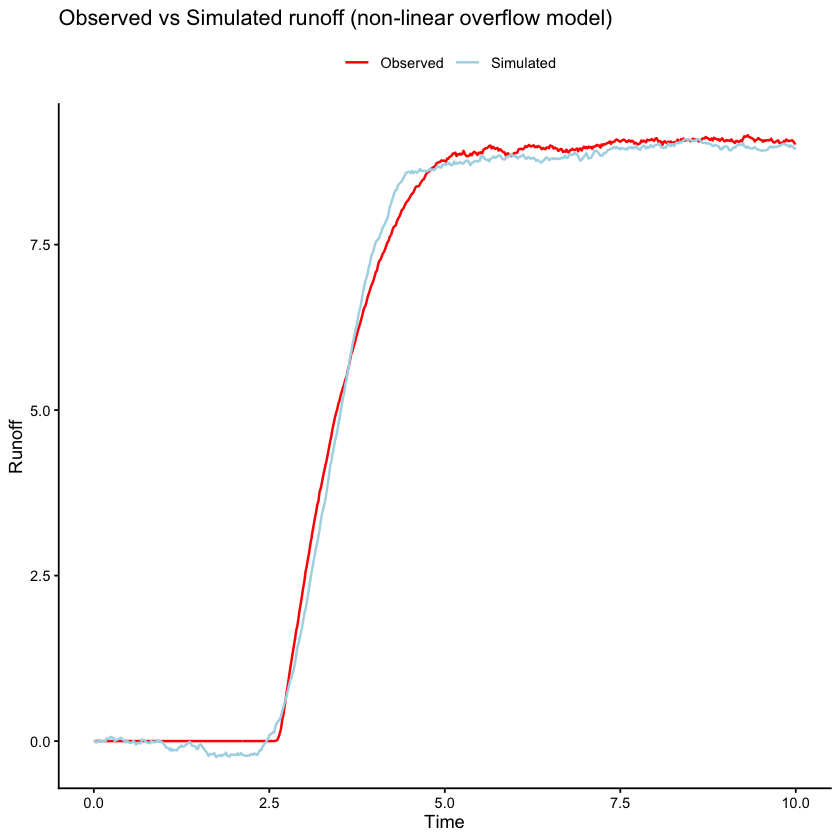

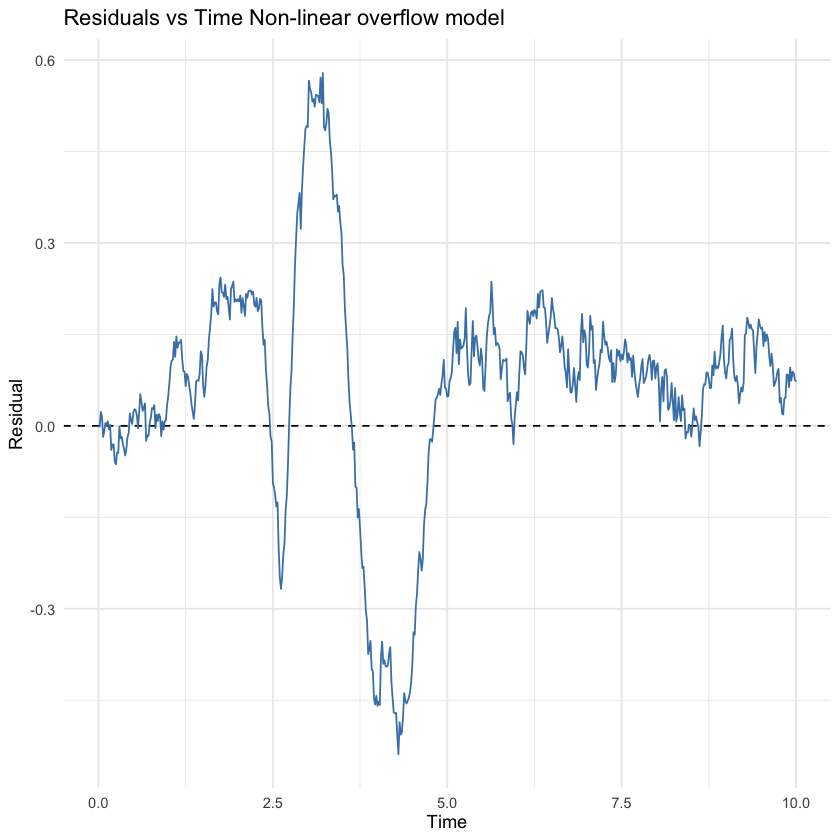

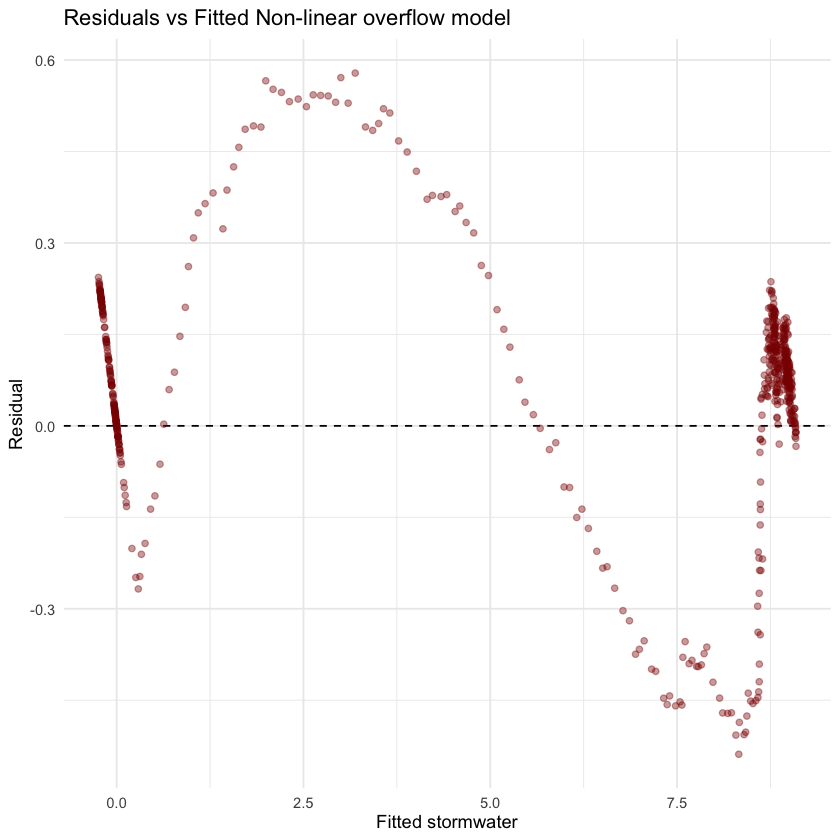

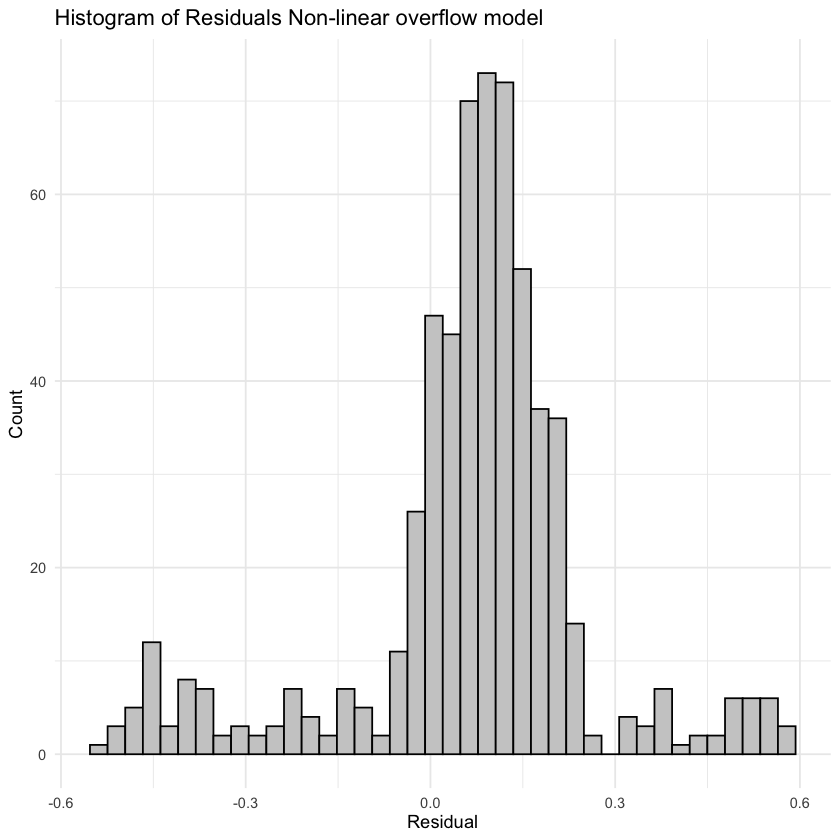

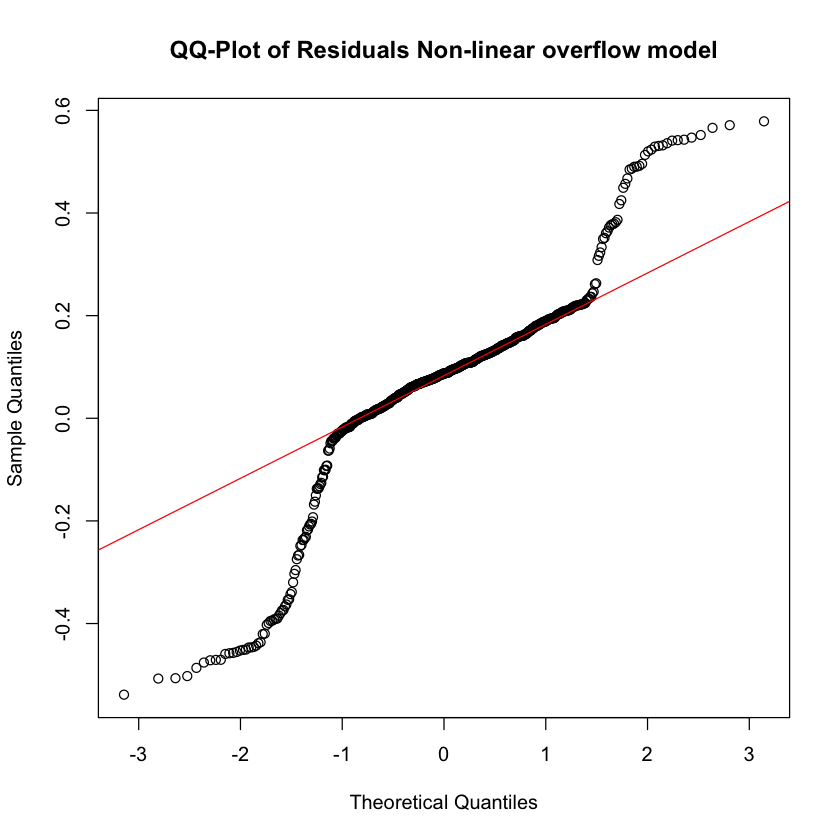

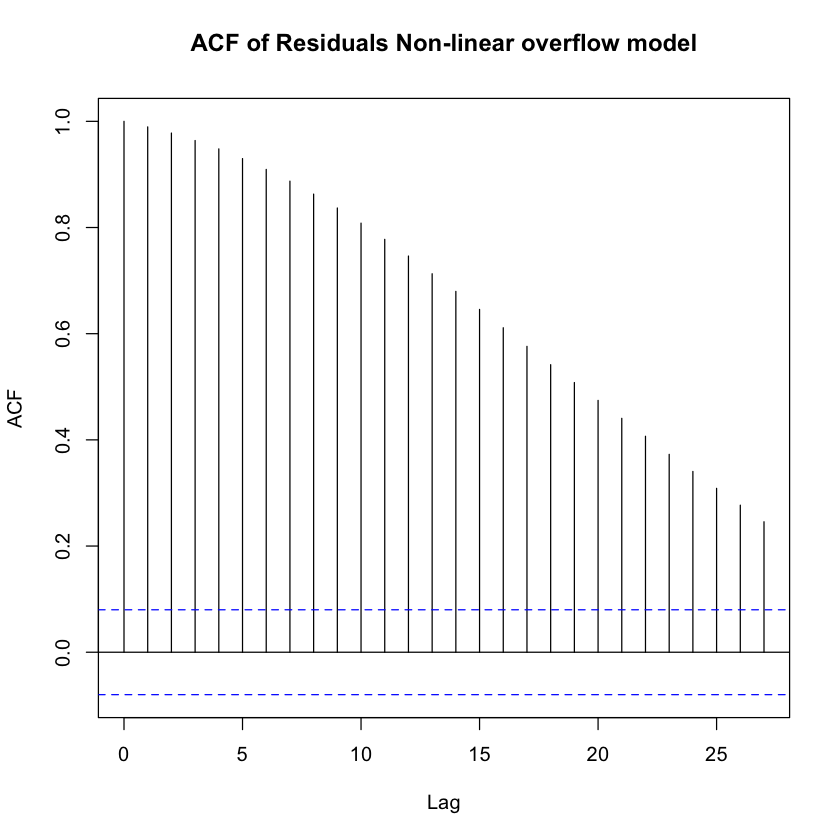

In [12]:

ggplot(df_plot, aes(x = time)) +
  geom_line(aes(y = observed,  color = "Observed"), linewidth = 0.7) +
  geom_line(aes(y = simulated, color = "Simulated"), linewidth = 0.7) +
  scale_color_manual(values = c("Observed" = "red",
                                "Simulated" = "lightblue")) +
  labs(
    title = "Observed vs Simulated runoff (non-linear overflow model)",
    y = "Runoff",
    x = "Time",
    color = ""
  ) +
  theme_classic() +
  theme(
    legend.position = "top",
    plot.title = element_text(size = 13)
  )

# ============================================================
# =============== Residual Analysis for 2.2.2 =================
# ============================================================

# 1) Compute residuals
df_plot$residual <- df_plot$observed - df_plot$simulated

# 2) Residuals vs Time
ggplot(df_plot, aes(x = time, y = residual)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  geom_line(color = "steelblue") +
  labs(
    title = "Residuals vs Time Non-linear overflow model",
    x = "Time", y = "Residual"
  ) +
  theme_minimal()

# 3) Residuals vs Fitted
ggplot(df_plot, aes(x = simulated, y = residual)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  geom_point(alpha = 0.4, color = "darkred") +
  labs(
    title = "Residuals vs Fitted Non-linear overflow model",
    x = "Fitted stormwater", y = "Residual"
  ) +
  theme_minimal()

# 4) Histogram of residuals
ggplot(df_plot, aes(x = residual)) +
  geom_histogram(bins = 40, colour = "black", fill = "grey80") +
  labs(
    title = "Histogram of Residuals Non-linear overflow model",
    x = "Residual", y = "Count"
  ) +
  theme_minimal()

# 5) QQ-Plot
qqnorm(df_plot$residual,
       main = "QQ-Plot of Residuals Non-linear overflow model")
qqline(df_plot$residual, col = "red")

# 6) Autocorrelation function (ACF)
acf(df_plot$residual,
    main = "ACF of Residuals Non-linear overflow model")
